In [7]:
import os
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prediction_utils.pytorch_utils.metrics import StandardEvaluator
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import pearsonr

pd.options.display.max_rows = 100

In [8]:
artifacts_fpath = '/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/experiments/baseline/artifacts'

evaluator = StandardEvaluator()

tasks = ['hospital_mortality','LOS_7','readmission_30','icu_admission']

## MODEL PERFORMANCE AND ROBUSTNESS

In [9]:
cmap = 'viridis'

y_axis = {
    'auc':{
        'lim':[-0.18, 0.18],
        'lim_raw':[0.6,.95],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[-0.25, 0.25],
        'lim_raw':[0,.75],
        'label':'AUPRC'
    },
    'ace_abs_logistic_logit':{
        'lim':[-0.01, 0.10],
        'lim_raw':[0,0.15],
        'label':'Calibration'
    },
    'loss_bce':{
        'lim':[0, 0.4],
        'label':'BCE Loss'
    }
}

metrics = {
    'auc':'AUROC',
    'auprc':'AUPRC',
    'ace_abs_logistic_logit':'Calibration',
}

titles = {
    'hospital_mortality':'In-Hospital Mortality',
    'LOS_7':'LOS > 7 Days',
    'readmission_30':'Readmission in 30 Days',
    'icu_admission':'Admission to ICU'
}

train_years = {
    '2009_2010_2011_2012':'09-12',
    #'2009_2010_2011_2012_2013':'09-13',
    #'2009_2010_2011_2012_2013_2014':'09-14',
    #'2009_2010_2011_2012_2013_2014_2015':'09-15',
    #'2009_2010_2011_2012_2013_2014_2015_2016':'09-16',
    #'2009_2010_2011_2012_2013_2014_2015_2016_2017':'09-17',
    #'2009_2010_2011_2012_2013_2014_2015_2016_2017_2018':'09-18',
}

#### Performance - all

In [10]:
df_results = pd.DataFrame(columns = ['Task','Train Group','Performance','Metric'])

c = 0
for task in tasks:
    for train_year in train_years:
        
        df_eval = pd.read_csv(os.path.join(
            artifacts_fpath,
            task,
            "eval",
            f"nn_{train_year}",
            "by_group.csv"
        )).round(3)
        
        for metric in metrics:
            c+=1
            mid = df_eval.query(f"metric==@metric and CI_quantile_95==['mid'] and test_group==@train_year")['baseline'].values[0]
            lower = df_eval.query("metric==@metric and CI_quantile_95==['lower'] and test_group==@train_year")['baseline'].values[0]
            upper = df_eval.query("metric==@metric and CI_quantile_95==['upper'] and test_group==@train_year")['baseline'].values[0]
            df_results.loc[c,'Performance'] = f"{mid} ({lower}, {upper})"
            df_results.loc[c,'Metric'] = metric
            df_results.loc[c,'Task'] = task
            df_results.loc[c,'Train Group'] = train_years[train_year]
df_results = df_results.replace({**titles,**metrics})
df_results = df_results.pivot(index=['Task','Metric'],columns='Train Group',values='Performance')
df_results = df_results.reindex(labels = ['In-Hospital Mortality','LOS > 7 Days','Readmission in 30 Days','Admission to ICU'], level=0)
df_results = df_results.reindex(labels = ['AUROC','AUPRC','Calibration'],level=1)
print('ID PERFORMANCE OF MODELS TRAINED ON VARIOUS YEAR GROUPS')
display(df_results)

ID PERFORMANCE OF MODELS TRAINED ON VARIOUS YEAR GROUPS


Train Group                                        09-12
Task                   Metric                           
In-Hospital Mortality  AUROC        0.821 (0.796, 0.843)
                       AUPRC        0.094 (0.075, 0.116)
                       Calibration  0.004 (0.002, 0.006)
LOS > 7 Days           AUROC        0.752 (0.739, 0.764)
                       AUPRC        0.445 (0.424, 0.467)
                       Calibration  0.008 (0.004, 0.014)
Readmission in 30 Days AUROC        0.755 (0.733, 0.777)
                       AUPRC        0.226 (0.192, 0.262)
                       Calibration   0.006 (0.003, 0.01)
Admission to ICU       AUROC        0.834 (0.816, 0.853)
                       AUPRC         0.35 (0.304, 0.395)
                       Calibration  0.009 (0.004, 0.013)

#### Robustness - 09-12 - delta

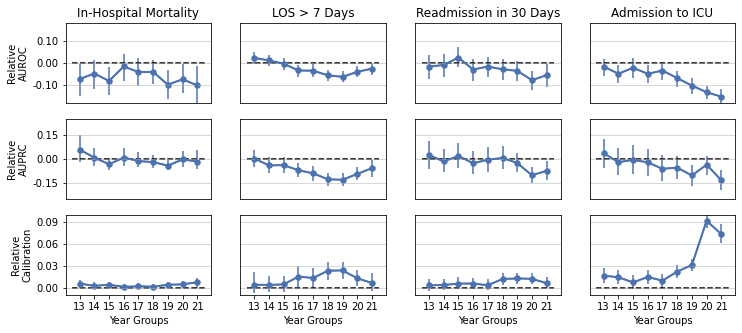

In [11]:
fig, axes = plt.subplots(nrows = len(metrics), ncols=len(tasks),figsize=(12,5))
for c,task in enumerate(tasks):
    
    df_eval = pd.read_csv(os.path.join(
        artifacts_fpath,
        task,
        "eval",
        "nn_2009_2010_2011_2012",
        "by_group.csv"
    ))
    
    for r,metric in enumerate(metrics):
        
        year_groups = list(set([
            x for x in df_eval['test_group'] 
            if x.isdigit()
            and x not in ['2009_2010_2011_2012','2010_2011_2012']
        ]))
        
        year_groups.sort()
        
        # baseline (0)
        axes[r][c].plot(
            [-0.5, len(year_groups)-0.5],
            [0,0],
            '--',
            c = 'black',
            zorder = 0
        )
        
        temp = df_eval.query("metric==@metric and test_group!=['2010_2011_2012','2009_2010_2011_2012']")
        data = temp.query("CI_quantile_95=='mid'").reset_index(drop=True)
        data['CI_upper'] = (
            temp.query("CI_quantile_95=='upper'").reset_index()['delta'] - 
            temp.query("CI_quantile_95=='mid'").reset_index()['delta']
        ).abs()
        data['CI_lower'] = (
            temp.query("CI_quantile_95=='lower'").reset_index()['delta'] - 
            temp.query("CI_quantile_95=='mid'").reset_index()['delta']
        ).abs()

        # line
        axes[r][c].plot(
            data['test_group'],
            data['delta'],
            linestyle='-',
            linewidth=2,
            color = sns.color_palette("deep")[0]
        )
        
        # scatter
        axes[r][c].scatter(
            data['test_group'],
            data['delta'],
            s = 20,
            linewidth=2,
            color = sns.color_palette("deep")[0]
        )

        # error bars
        axes[r][c].errorbar(
            data['test_group'],
            data['delta'],
            data[['CI_lower','CI_upper']].values.T,
            zorder = 0,
            linewidth = 1.5,
            color = sns.color_palette("deep")[0]
        )
        
        ## Axes settings
        axes[r][c].set_ylim(y_axis[metric]['lim'])
        axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
        axes[r][c].grid(which='major', linewidth=0.5, axis='y')
        if r==0:
            axes[r][c].set_title(titles[task])

        if r==len(metrics)-1:
            axes[r][c].set_xticks(year_groups)
            axes[r][c].set_xticklabels([x[-2:] for x in year_groups])
            axes[r][c].set_xlabel('Year Groups')
        else:
            axes[r][c].set_xticklabels('')
            axes[r][c].set_xlabel('')
            axes[r][c].tick_params(axis='x', length=0)

        if c == 0:
            axes[r][c].set_ylabel(f"Relative\n{y_axis[metric]['label']}")
            axes[r][c].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            axes[r][c].set_yticklabels('')
            axes[r][c].set_ylabel('')
            #axes[r][c].spines['left'].set_color('white')
            axes[r][c].tick_params(axis='y', length=0)

        #sns.despine(offset=10, trim = True) 
plt.show()

## SUPPLEMENT

In [6]:
y_axis = {
    'auc':{
        'lim':[0.65, 1],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[0.1, 0.6],
        'label':'AUPRC'
    },
    'ace_abs_logistic_logit':{
        'lim':[-0.02, 0.13],
        'label':'Calibration'
    },
    'loss_bce':{
        'lim':[0, 0.4],
        'label':'BCE Loss'
    }
}
titles = {
    'hospital_mortality':'In-Hospital Mortality',
    'LOS_7':'LOS > 7 Days',
    'readmission_30':'Readmission in 30 Days',
    'icu_admission':'Admission to ICU'
}

##### With all year-groups

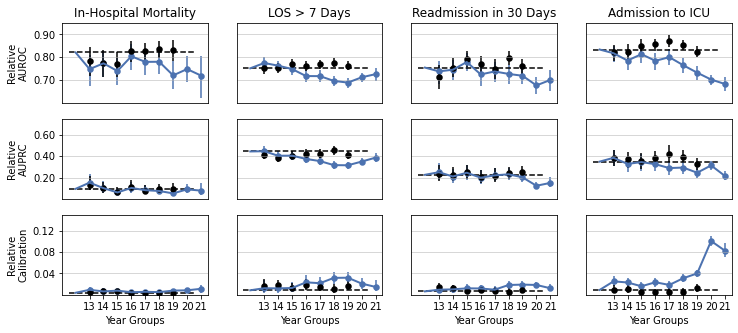

In [13]:
fig, axes = plt.subplots(nrows = len(metrics), ncols=len(tasks),figsize=(12,5))
for c,task in enumerate(tasks):
    
    df_eval_base = pd.read_csv(os.path.join(
        artifacts_fpath,
        task,
        "eval",
        "nn_2009_2010_2011_2012",
        "by_group.csv"
    ))
    
    for r,metric in enumerate(metrics):
        
        year_groups = list(set([
            x for x in df_eval_base['test_group']
            if x not in ['2009_2010_2011_2012','2010_2011_2012']
        ]))
        
        # baseline (0)
        base_value = df_eval_base.query(
            "metric==@metric and test_group=='2009_2010_2011_2012' and CI_quantile_95=='mid'"
        )['baseline'].values[0]
        
        axes[r][c].plot(
            [-0.5, len(year_groups)-0.5],
            [base_value,base_value],
            '--',
            c = 'black',
            zorder = 0
        )
        
        year_groups.sort()
        df_eval_id = pd.concat((
            pd.read_csv(os.path.join(
                artifacts_fpath,
                task,
                "eval",
                f"nn_{group}",
                "by_group.csv"
            )).assign(train_group=int(group)) for group in year_groups if group not in ['2020','2021']
        ))
        df_eval_id['test_group'] = df_eval_id['test_group'].astype(str)
        df_eval_id['train_group'] = df_eval_id['train_group'].astype(str)
        df_eval_id = df_eval_id.query("test_group==train_group")
        
        # line
        axes[r][c].plot(
            df_eval_base.query("CI_quantile_95=='mid' and metric==@metric")['test_group'],
            df_eval_base.query("CI_quantile_95=='mid' and metric==@metric")['comparator'],
            linestyle='-',
            linewidth=2,
            color = sns.color_palette("deep")[0]
        )
        
        for group in year_groups:
            base = df_eval_base.query("test_group==@group and metric==@metric and CI_quantile_95=='mid'")[
                ['test_group','comparator']
            ]
            
            base['CI_upper'] = np.abs(
                df_eval_base.query("test_group==@group and metric==@metric and CI_quantile_95=='upper'")['comparator'].values - 
                df_eval_base.query("test_group==@group and metric==@metric and CI_quantile_95=='mid'")['comparator'].values
            )
            
            base['CI_lower'] = np.abs(
                df_eval_base.query("test_group==@group and metric==@metric and CI_quantile_95=='lower'")['comparator'].values - 
                df_eval_base.query("test_group==@group and metric==@metric and CI_quantile_95=='mid'")['comparator'].values
            )
            
            retrained = df_eval_id.query("test_group==@group and metric==@metric and CI_quantile_95=='mid'")[
                ['test_group','baseline']
            ]
            
            retrained['CI_upper'] = np.abs(
                df_eval_id.query("test_group==@group and metric==@metric and CI_quantile_95=='upper'")['baseline'].values - 
                df_eval_id.query("test_group==@group and metric==@metric and CI_quantile_95=='mid'")['baseline'].values
            )
            
            retrained['CI_lower'] = np.abs(
                df_eval_id.query("test_group==@group and metric==@metric and CI_quantile_95=='lower'")['baseline'].values - 
                df_eval_id.query("test_group==@group and metric==@metric and CI_quantile_95=='mid'")['baseline'].values
            )
            
            
            # scatter
            axes[r][c].scatter(
                base['test_group'],
                base['comparator'],
                s = 20,
                linewidth=2,
                color = sns.color_palette("deep")[0]
            )

            # error bars
            axes[r][c].errorbar(
                base['test_group'],
                base['comparator'],
                base[['CI_lower','CI_upper']].values.T,
                zorder = 0,
                linewidth = 1.5,
                color = sns.color_palette("deep")[0]
            )
            
            # scatter
            axes[r][c].scatter(
                retrained['test_group'],
                retrained['baseline'],
                s = 20,
                linewidth=2,
                color = 'black'
            )

            # error bars
            axes[r][c].errorbar(
                retrained['test_group'],
                retrained['baseline'],
                retrained[['CI_lower','CI_upper']].values.T,
                zorder = 0,
                linewidth = 1.5,
                color = 'black'
            )
        ## Axes settings
        axes[r][c].set_ylim(y_axis[metric]['lim_raw'])
        axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
        axes[r][c].grid(which='major', linewidth=0.5, axis='y')
        if r==0:
            axes[r][c].set_title(titles[task])

        if r==len(metrics)-1:
            axes[r][c].set_xticks(year_groups)
            axes[r][c].set_xticklabels([x[-2:] for x in year_groups])
            axes[r][c].set_xlabel('Year Groups')
        else:
            axes[r][c].set_xticklabels('')
            axes[r][c].set_xlabel('')
            axes[r][c].tick_params(axis='x', length=0)

        if c == 0:
            axes[r][c].set_ylabel(f"Relative\n{y_axis[metric]['label']}")
            axes[r][c].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            axes[r][c].set_yticklabels('')
            axes[r][c].set_ylabel('')
            #axes[r][c].spines['left'].set_color('white')
            axes[r][c].tick_params(axis='y', length=0)

        #sns.despine(offset=10, trim = True) 
plt.show()